# Generate cellxgene

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import os
import sys

sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './figures/'
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

'/home/jovyan/my-conda-envs/sc_analysis/bin/python'

# Prepare INPUT

## Load raw and annoted andata

In [2]:
path_to_gonads = '/nfs/team292/lg18/with_valentina/gonadsV2_revision/'

### Read in Sanger dataset

In [3]:
sanger = sc.read(path_to_gonads + 'mouse-gonads_rawcounts.h5ad')
sanger.X.shape

(64879, 24482)

### Read in Niu dataset

In [4]:
niu = sc.read('/nfs/team292/vl6/Mouse_Niu2020/mouse_annotated.h5ad')
niu = anndata.AnnData(X=niu.raw.X, var=niu.raw.var, obs=niu.obs, asview=False)

### Merged

In [5]:
sanger.obs['dataset'] = 'Sanger'
niu.obs['dataset'] = 'Niu2020'
niu.obs['sex'] = 'female'
niu.obs['location'] = 'gonad'
adata = sanger.concatenate(niu,
                    batch_key = 'dataset', 
                batch_categories = ['Sanger', 'Niu2020'], 
                                  join = 'outer')

In [6]:
adata_annotated = sc.read(path_to_gonads+'/mouse-gonads_somatic.h5ad')
adata_annotated.X.shape

(52180, 24215)

### Import lineage and somatic annotation

In [7]:
cell_annot = adata_annotated.obs['lineage'].to_dict()
adata.obs['lineage'] = adata.obs_names.map(cell_annot)
adata.obs['lineage'].value_counts()

Mesenchymal_Lhx9    15305
preGranulosa        13228
Supporting           8030
CoelEpi_Lhx9         7447
CoelEpi_Gata2        6513
Sertoli              1491
FetalLeydig           166
Name: lineage, dtype: int64

In [8]:
cell_annot = adata_annotated.obs['celltype'].to_dict()
adata.obs['celltype'] = adata.obs_names.map(cell_annot)
adata.obs['celltype'].value_counts()

Oi                       7649
preGC_II                 7556
CoelEpi_Lhx9             6632
CoelEpi_Gata2            6143
Gi                       5836
preGC_I                  4719
early_supporting         4072
Ti                       2019
granulosa                1919
sPAX8                    1689
Sertoli                  1516
OSE                      1031
lowQC                     523
CoelEpi_Gata2_cycling     424
cont                      219
FetalLeydig               199
Doublet                    34
Name: celltype, dtype: int64

## Remove lowQC cells and artifacts

In [19]:
adata = adata[[ not pd.isna(i) for i in adata.obs.celltype]]
adata = adata[[i not in ['lowQC', 'Doublet', 'cont'] for i in adata.obs.lineage]]
adata = adata[[i not in ['lowQC', 'Doublet', 'cont'] for i in adata.obs.celltype]]
adata = adata[[not i for i in adata.obs.is_doublet]]

In [20]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['celltype'].value_counts()

Total number of cells: 50933
Total number of genes: 26455


Oi                       7646
preGC_II                 7555
CoelEpi_Lhx9             6590
CoelEpi_Gata2            6075
Gi                       5826
preGC_I                  4549
early_supporting         4019
Ti                       2014
granulosa                1918
sPAX8                    1684
Sertoli                  1403
OSE                      1031
CoelEpi_Gata2_cycling     424
FetalLeydig               199
Name: celltype, dtype: int64

## Import UMAP

In [21]:
adata_annotated = adata_annotated[[ i in adata.obs_names for i in adata_annotated.obs_names ]]

In [22]:
adata.obsm['X_umap'] = adata_annotated.obsm['X_umap']
adata.obsm['X_scVI'] = adata_annotated.obsm['X_scVI']
# adata.obsp['connectivities'] = adata_annotated.obsp['connectivities']
# adata.obsp['distances'] = adata_annotated.obsp['distances']
# adata.uns['celltype_colors'] = adata_annotated.uns['celltype_colors']
# adata.uns['neighbors'] = adata_annotated.uns['neighbors']

## Remove un necessary data

In [23]:
del adata_annotated

In [26]:
adata.obs.head()

,n_genes,sample,stage,sex,location,percent_mito,n_counts,batch,S_score,G2M_score,phase,scrublet_score,scrublet_cluster_score,zscore,bh_pval,bonf_pval,is_doublet,lineage,dataset,celltype
HCA_Mou_10827181_AAACCTGAGTAGATGT-Sanger,4478,HCA_Mou_10827181,12.5,male,gonad,0.021894,14342.0,0,0.244737,-1.118329,S,0.083710,0.066800,0.419175,0.830436,1.0,0,Mesenchymal_Lhx9,Sanger,Ti
HCA_Mou_10827181_AAACCTGAGTCATGCT-Sanger,3796,HCA_Mou_10827181,12.5,male,gonad,0.022123,10261.0,0,-0.584211,-0.958706,G1,0.047059,0.086505,0.969856,0.830436,1.0,0,Mesenchymal_Lhx9,Sanger,Ti
HCA_Mou_10827181_AAACCTGCAAGAGTCG-Sanger,5995,HCA_Mou_10827181,12.5,male,gonad,0.014868,28316.0,0,0.171053,-2.909845,S,0.031564,0.053708,0.053337,0.830436,1.0,0,CoelEpi_Lhx9,Sanger,CoelEpi_Lhx9
HCA_Mou_10827181_AAACCTGCAGACACTT-Sanger,4818,HCA_Mou_10827181,12.5,male,gonad,0.017001,16293.0,0,1.352632,1.623118,G2M,0.047059,0.064706,0.360665,0.830436,1.0,0,Mesenchymal_Lhx9,Sanger,Ti
HCA_Mou_10827181_AAACCTGCATGCCTTC-Sanger,4590,HCA_Mou_10827181,12.5,male,gonad,0.013677,14769.0,0,-0.960526,-1.341705,G1,0.062681,0.083710,0.891755,0.830436,1.0,0,Mesenchymal_Lhx9,Sanger,Ti


In [25]:
del adata.obs['scmap_fromHuman']
del adata.obs['tissue']
del adata.obs['leiden']
del adata.obs['cell_type']
del adata.obs['doublet_score']
del adata.obs['doublet_score_0.75']

# Normalize data

In [27]:
adata.raw = adata.copy()

In [28]:
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)                                                                                                            
# sc.pp.scale(adata, max_value=10)

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


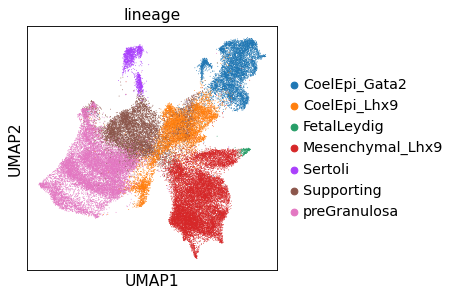

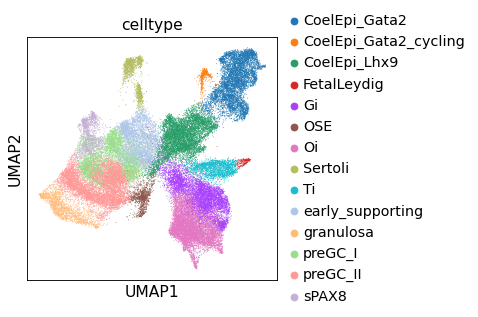

In [30]:
sc.pl.umap(adata, color='lineage')
sc.pl.umap(adata, color='celltype')

In [32]:
adata.write('/nfs/cellgeni/tickets/tic-613/mouse_somatic.h5ad')